# Julia for Data Analysis

## Bogumił Kamiński

# Lecture 11. Converting and grouping data frames

## Converting a data frame to other value types

In [ ]:
using Pkg
Pkg.activate(Base.current_project())

In [1]:
using DataFrames
using Serialization
walk = deserialize("walk.bin")

,x,y
,Int64,Int64
1,0,0
2,0,1
3,0,2
4,0,3
5,1,3
6,1,4
7,1,5
8,1,6
9,0,6


In [2]:
x = [1.5]

1-element Vector{Float64}:
 1.5

In [3]:
x[1] = 1

1

In [4]:
x

1-element Vector{Float64}:
 1.0

### Conversion to a matrix

In [5]:
Matrix(walk)

11×2 Matrix{Int64}:
 0  0
 0  1
 0  2
 0  3
 1  3
 1  4
 1  5
 1  6
 0  6
 0  7
 0  8

In [6]:
Matrix{Any}(walk)

11×2 Matrix{Any}:
 0  0
 0  1
 0  2
 0  3
 1  3
 1  4
 1  5
 1  6
 0  6
 0  7
 0  8

In [7]:
Matrix{String}(walk)

LoadError: MethodError: [0mCannot `convert` an object of type [92mInt64[39m[0m to an object of type [91mString[39m
[0mClosest candidates are:
[0m  convert(::Type{String}, [91m::String[39m) at C:\WORK\julia-1.7.3\share\julia\base\essentials.jl:223
[0m  convert(::Type{T}, [91m::T[39m) where T<:AbstractString at C:\WORK\julia-1.7.3\share\julia\base\strings\basic.jl:231
[0m  convert(::Type{T}, [91m::AbstractString[39m) where T<:AbstractString at C:\WORK\julia-1.7.3\share\julia\base\strings\basic.jl:232
[0m  ...

In [8]:
using Plots
plot(walk)

LoadError: Cannot convert DataFrame to series data for plotting

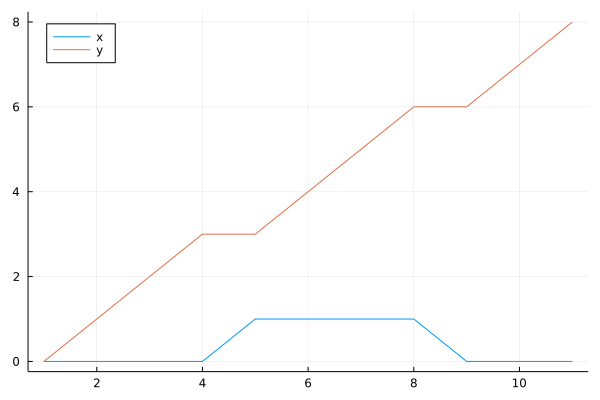

In [9]:
plot(Matrix(walk); labels=["x" "y"] , legend=:topleft)

### Conversion to a named tuple of vectors

In [10]:
Tables.columntable(walk)

(x = [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0], y = [0, 1, 2, 3, 3, 4, 5, 6, 6, 7, 8])

### Type stability in Julia

In [11]:
using BenchmarkTools
function mysum(table)
    s = 0 #A
    for v in table.x #B
        s += v
    end
    return s
end

mysum (generic function with 1 method)

In [12]:
df = DataFrame(x=1:1_000_000);
@btime mysum($df)

  84.713 ms (3998948 allocations: 76.28 MiB)


500000500000

In [13]:
tab = Tables.columntable(df);
@btime mysum($tab)

  134.500 μs (0 allocations: 0 bytes)


500000500000

In [14]:
@code_warntype mysum(df)

MethodInstance for mysum(::DataFrame)
  from mysum(table) in Main at In[11]:2
Arguments
  #self#::Core.Const(mysum)
  table::DataFrame
Locals
  @_3::Any
  s::Any
  v::Any
Body::Any
1 ─       (s = 0)
│   %2  = Base.getproperty(table, :x)::AbstractVector
│         (@_3 = Base.iterate(%2))
│   %4  = (@_3 === nothing)::Bool
│   %5  = Base.not_int(%4)::Bool
└──       goto #4 if not %5
2 ┄ %7  = @_3::Any
│         (v = Core.getfield(%7, 1))
│   %9  = Core.getfield(%7, 2)::Any
│         (s = s + v)
│         (@_3 = Base.iterate(%2, %9))
│   %12 = (@_3 === nothing)::Bool
│   %13 = Base.not_int(%12)::Bool
└──       goto #4 if not %13
3 ─       goto #2
4 ┄       return s



In [15]:
@code_warntype mysum(tab)

MethodInstance for mysum(::NamedTuple{(:x,), Tuple{Vector{Int64}}})
  from mysum(table) in Main at In[11]:2
Arguments
  #self#::Core.Const(mysum)
  table::NamedTuple{(:x,), Tuple{Vector{Int64}}}
Locals
  @_3::Union{Nothing, Tuple{Int64, Int64}}
  s::Int64
  v::Int64
Body::Int64
1 ─       (s = 0)
│   %2  = Base.getproperty(table, :x)::Vector{Int64}
│         (@_3 = Base.iterate(%2))
│   %4  = (@_3 === nothing)::Bool
│   %5  = Base.not_int(%4)::Bool
└──       goto #4 if not %5
2 ┄ %7  = @_3::Tuple{Int64, Int64}
│         (v = Core.getfield(%7, 1))
│   %9  = Core.getfield(%7, 2)::Int64
│         (s = s + v)
│         (@_3 = Base.iterate(%2, %9))
│   %12 = (@_3 === nothing)::Bool
│   %13 = Base.not_int(%12)::Bool
└──       goto #4 if not %13
3 ─       goto #2
4 ┄       return s



In [16]:
typeof(tab)

NamedTuple{(:x,), Tuple{Vector{Int64}}}

### Overcoming type instability

In [17]:
function barrier_mysum2(x)
    s = 0
    for v in x
        s += v
    end
    return s
end

barrier_mysum2 (generic function with 1 method)

In [18]:
mysum2(table) = barrier_mysum2(table.x)

mysum2 (generic function with 1 method)

In [19]:
@btime mysum2($df)

  135.100 μs (1 allocation: 16 bytes)


500000500000

### Type piracy in Julia

In [20]:
df = DataFrame(a=[1, 1, 2], b=[1, 1, 2])

,a,b
,Int64,Int64
1,1,1
2,1,1
3,2,2


In [21]:
unique(df)

,a,b
,Int64,Int64
1,1,1
2,2,2


In [22]:
tab = Tables.columntable(df)

(a = [1, 1, 2], b = [1, 1, 2])

In [23]:
unique(tab)

1-element Vector{Vector{Int64}}:
 [1, 1, 2]

### Other common conversions

#### Vector of NamedTuple

In [24]:
Tables.rowtable(walk)

11-element Vector{NamedTuple{(:x, :y), Tuple{Int64, Int64}}}:
 (x = 0, y = 0)
 (x = 0, y = 1)
 (x = 0, y = 2)
 (x = 0, y = 3)
 (x = 1, y = 3)
 (x = 1, y = 4)
 (x = 1, y = 5)
 (x = 1, y = 6)
 (x = 0, y = 6)
 (x = 0, y = 7)
 (x = 0, y = 8)

#### Iterator of NamedTuple

In [25]:
nti = Tables.namedtupleiterator(walk)

Tables.NamedTupleIterator{Tables.Schema{(:x, :y), Tuple{Int64, Int64}}, Tables.RowIterator{NamedTuple{(:x, :y), Tuple{Vector{Int64}, Vector{Int64}}}}}(Tables.RowIterator{NamedTuple{(:x, :y), Tuple{Vector{Int64}, Vector{Int64}}}}((x = [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0], y = [0, 1, 2, 3, 3, 4, 5, 6, 6, 7, 8]), 11))

In [26]:
for v in nti
    println(v)
end

(x = 0, y = 0)
(x = 0, y = 1)
(x = 0, y = 2)
(x = 0, y = 3)
(x = 1, y = 3)
(x = 1, y = 4)
(x = 1, y = 5)
(x = 1, y = 6)
(x = 0, y = 6)
(x = 0, y = 7)
(x = 0, y = 8)


### Type unstable iterators of rows and columns

In [27]:
er = eachrow(walk)

,x,y
,Int64,Int64
1,0,0
2,0,1
3,0,2
4,0,3
5,1,3
6,1,4
7,1,5
8,1,6
9,0,6


In [28]:
er[1]

,x,y
,Int64,Int64
1,0,0


In [29]:
er[end]

,x,y
,Int64,Int64
11,0,8


In [30]:
ec = eachcol(walk)

,x,y
,Int64,Int64
1,0,0
2,0,1
3,0,2
4,0,3
5,1,3
6,1,4
7,1,5
8,1,6
9,0,6


In [31]:
ec[1]

11-element Vector{Int64}:
 0
 0
 0
 0
 1
 1
 1
 1
 0
 0
 0

In [32]:
ec[end]

11-element Vector{Int64}:
 0
 1
 2
 3
 3
 4
 5
 6
 6
 7
 8

### Vector of vectors

In [33]:
identity.(eachcol(walk))

2-element Vector{Vector{Int64}}:
 [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0]
 [0, 1, 2, 3, 3, 4, 5, 6, 6, 7, 8]

In [34]:
df = DataFrame(x=1:2, b=["a", "b"])

,x,b
,Int64,String
1,1,a
2,2,b


In [35]:
identity.(eachcol(df))

2-element Vector{Vector}:
 [1, 2]
 ["a", "b"]

## Grouping data frame objects

### Preparing the source data frame

In [36]:
using CSV
raw_data = """
city,date,rainfall
Olecko,2020-11-16,2.9
Olecko,2020-11-17,4.1
Olecko,2020-11-19,4.3
Olecko,2020-11-20,2.0
Olecko,2020-11-21,0.6
Olecko,2020-11-22,1.0
Ełk,2020-11-16,3.9
Ełk,2020-11-19,1.2
Ełk,2020-11-20,2.0
Ełk,2020-11-22,2.0
""";
rainfall_df = CSV.read(IOBuffer(raw_data), DataFrame)

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9
2,Olecko,2020-11-17,4.1
3,Olecko,2020-11-19,4.3
4,Olecko,2020-11-20,2.0
5,Olecko,2020-11-21,0.6
6,Olecko,2020-11-22,1.0
7,Ełk,2020-11-16,3.9
8,Ełk,2020-11-19,1.2
9,Ełk,2020-11-20,2.0


### Grouping a data frame

In [37]:
gdf_city = groupby(rainfall_df, "city")

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9
2,Olecko,2020-11-17,4.1
3,Olecko,2020-11-19,4.3
4,Olecko,2020-11-20,2.0
5,Olecko,2020-11-21,0.6
6,Olecko,2020-11-22,1.0
,city,date,rainfall
,String7,Date,Float64
1,Ełk,2020-11-16,3.9


In [38]:
gdf_city_date = groupby(rainfall_df, Not("rainfall"))

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9
,city,date,rainfall
,String7,Date,Float64
1,Ełk,2020-11-22,2.0


### Getting group keys of a grouped data frame

In [39]:
keys(gdf_city_date)

10-element DataFrames.GroupKeys{GroupedDataFrame{DataFrame}}:
 GroupKey: (city = "Olecko", date = Dates.Date("2020-11-16"))
 GroupKey: (city = "Olecko", date = Dates.Date("2020-11-17"))
 GroupKey: (city = "Olecko", date = Dates.Date("2020-11-19"))
 GroupKey: (city = "Olecko", date = Dates.Date("2020-11-20"))
 GroupKey: (city = "Olecko", date = Dates.Date("2020-11-21"))
 GroupKey: (city = "Olecko", date = Dates.Date("2020-11-22"))
 GroupKey: (city = "Ełk", date = Dates.Date("2020-11-16"))
 GroupKey: (city = "Ełk", date = Dates.Date("2020-11-19"))
 GroupKey: (city = "Ełk", date = Dates.Date("2020-11-20"))
 GroupKey: (city = "Ełk", date = Dates.Date("2020-11-22"))

In [40]:
gk1 = keys(gdf_city_date)[1]

GroupKey: (city = "Olecko", date = Dates.Date("2020-11-16"))

In [41]:
g1_t = Tuple(gk1)

("Olecko", Dates.Date("2020-11-16"))

In [42]:
g1_nt = NamedTuple(gk1)

(city = "Olecko", date = Dates.Date("2020-11-16"))

In [43]:
g1_dict = Dict(gk1)

Dict{Symbol, Any} with 2 entries:
  :date => Date("2020-11-16")
  :city => "Olecko"

### Indexing grouped data frame with a single value

In [44]:
gdf_city_date[1]

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9


In [45]:
gdf_city_date[gk1]

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9


In [46]:
gdf_city_date[g1_t]

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9


In [47]:
gdf_city_date[g1_nt]

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9


In [48]:
gdf_city_date[g1_dict]

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9


In [49]:
gdf_city[("Olecko",)]

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9
2,Olecko,2020-11-17,4.1
3,Olecko,2020-11-19,4.3
4,Olecko,2020-11-20,2.0
5,Olecko,2020-11-21,0.6
6,Olecko,2020-11-22,1.0


In [50]:
gdf_city[(city="Olecko",)]

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9
2,Olecko,2020-11-17,4.1
3,Olecko,2020-11-19,4.3
4,Olecko,2020-11-20,2.0
5,Olecko,2020-11-21,0.6
6,Olecko,2020-11-22,1.0


### Comparison of performance of indexing methods

The presented tests were run on a machine having 32 GB of RAM. If you have less RAM and would like to reproduce it please decrease the number of rows in the bench_df data frame to, for example, 10^7.

In [51]:
using BenchmarkTools
bench_df = DataFrame(id=1:10^8);
bench_gdf = groupby(bench_df, :id);
@btime groupby($bench_df, :id);

  276.309 ms (87 allocations: 858.31 MiB)


In [52]:
bench_i = 1_000_000;
bench_gk = keys(bench_gdf)[bench_i];
bench_t = Tuple(bench_gk);
bench_nt = NamedTuple(bench_gk);
bench_dict = Dict(bench_gk);
@btime $bench_gdf[$bench_i];

  286.207 ns (7 allocations: 176 bytes)


In [53]:
@btime $bench_gdf[$bench_gk];

  342.202 ns (9 allocations: 208 bytes)


In [54]:
@btime $bench_gdf[$bench_t];

  458.883 ns (10 allocations: 224 bytes)


In [55]:
@btime $bench_gdf[$bench_nt];

  533.333 ns (12 allocations: 256 bytes)


In [56]:
@btime $bench_gdf[$bench_dict];

  633.929 ns (15 allocations: 304 bytes)


### Indexing grouped data frame with multiple values

In [57]:
gdf_city[[2, 1]]

,city,date,rainfall
,String7,Date,Float64
1,Ełk,2020-11-16,3.9
2,Ełk,2020-11-19,1.2
3,Ełk,2020-11-20,2.0
4,Ełk,2020-11-22,2.0
,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9
2,Olecko,2020-11-17,4.1
3,Olecko,2020-11-19,4.3


In [58]:
gdf_city[[1]]

,city,date,rainfall
,String7,Date,Float64
1,Olecko,2020-11-16,2.9
2,Olecko,2020-11-17,4.1
3,Olecko,2020-11-19,4.3
4,Olecko,2020-11-20,2.0
5,Olecko,2020-11-21,0.6
6,Olecko,2020-11-22,1.0


### Iterating grouped data frame

In [59]:
[nrow(df) for df in gdf_city]

2-element Vector{Int64}:
 6
 4

In [60]:
for p in pairs(gdf_city)
    println(p)
end

GroupKey: (city = "Olecko",) => 6×3 SubDataFrame
 Row │ city     date        rainfall 
     │ String7  Date        Float64  
─────┼───────────────────────────────
   1 │ Olecko   2020-11-16       2.9
   2 │ Olecko   2020-11-17       4.1
   3 │ Olecko   2020-11-19       4.3
   4 │ Olecko   2020-11-20       2.0
   5 │ Olecko   2020-11-21       0.6
   6 │ Olecko   2020-11-22       1.0
GroupKey: (city = "Ełk",) => 4×3 SubDataFrame
 Row │ city     date        rainfall 
     │ String7  Date        Float64  
─────┼───────────────────────────────
   1 │ Ełk      2020-11-16       3.9
   2 │ Ełk      2020-11-19       1.2
   3 │ Ełk      2020-11-20       2.0
   4 │ Ełk      2020-11-22       2.0


In [61]:
Dict(key.city => nrow(df) for (key, df) in pairs(gdf_city))

Dict{String7, Int64} with 2 entries:
  "Ełk"    => 4
  "Olecko" => 6

In [62]:
combine(gdf_city, nrow)

,city,nrow
,String7,Int64
1,Olecko,6
2,Ełk,4
